In [1]:
!pip install wandb

In [2]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
# Import required modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
!unzip /content/archive.zip

Archive:  /content/archive.zip
  inflating: london_weather.csv      


In [5]:
# Initialize a run
run = wandb.init(project="London Temperature predicting ML",
                 job_type="Baseline modeling",
                 save_code=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: abrarahmedislamians. Use `wandb login --relogin` to force relogin


In [6]:
original_data = "/content/london_weather.csv"
# Create an Artifact
data_artifact = wandb.Artifact(name="original_dataset",
                               type="data",
                               description="London weather dataset")
# Add the file to the Artifact
data_artifact.add_file(original_data)
# Log the Artifact as part of the run
run.log_artifact(data_artifact)

<Artifact original_dataset>

In [7]:
# Read in the data
london = pd.read_csv(original_data)

# Previewing the first five rows
london.head()

,date,cloud_cover,sunshine,global_radiation,max_temp,mean_temp,min_temp,precipitation,pressure,snow_depth
0,19790101,2.0,7.0,52.0,2.3,-4.1,-7.5,0.4,101900.0,9.0
1,19790102,6.0,1.7,27.0,1.6,-2.6,-7.5,0.0,102530.0,8.0
2,19790103,5.0,0.0,13.0,1.3,-2.8,-7.2,0.0,102050.0,4.0
3,19790104,8.0,0.0,13.0,-0.3,-2.6,-6.5,0.0,100840.0,2.0
4,19790105,6.0,2.0,29.0,5.6,-0.8,-1.4,0.0,102250.0,1.0


<Figure size 1200x800 with 0 Axes>

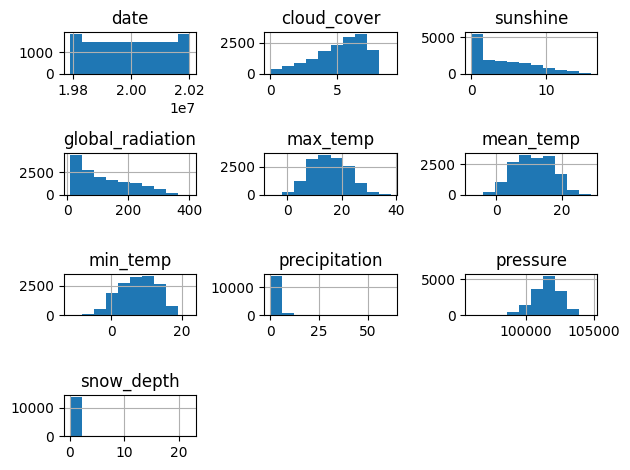

In [8]:
# Visualize distributions
plt.figure(figsize=(12,8))
london.hist()
plt.tight_layout()
plt.show()

In [10]:
# View data types and non-null counts
london.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


In [11]:

# Convert date to datetime
london["date"] = pd.to_datetime(london["date"], format="%Y%m%d")

# Add a month column
london["month"] = london["date"].dt.month

# Drop missing values
london.dropna(inplace=True)

In [12]:
# Save and log the new version of the data
london.to_csv("london_weather_preprocessed.csv", index=False)

In [13]:

preprocessed_data = "/content/london_weather_preprocessed.csv"
# Create an Artifact
preprocessed_data_artifact = wandb.Artifact(name="london_weather_preprocessed",
                               type="data",
                               description="London weather dataset - preprocessed")
# Add the file to the Artifact
preprocessed_data_artifact.add_file(preprocessed_data)
# Log the Artifact as part of the run
run.log_artifact(preprocessed_data_artifact)


<Artifact london_weather_preprocessed>

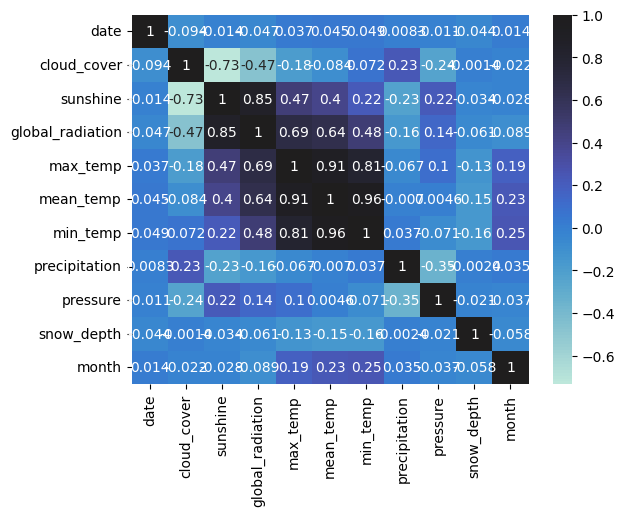

In [14]:
# Correlation heatmap
sns.heatmap(london.corr(), annot=True, center=True)
plt.show()

In [15]:
# Log the heatmap
wandb.log({"correlation_heatmap": wandb.Image(plt)})

<Figure size 640x480 with 0 Axes>

In [16]:

# Split the data
X = london.drop(columns=["mean_temp", "min_temp", "max_temp", "date"])
y = london["mean_temp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [17]:
# Build a Ridge regression model
ridge = Ridge(alpha=0.1)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

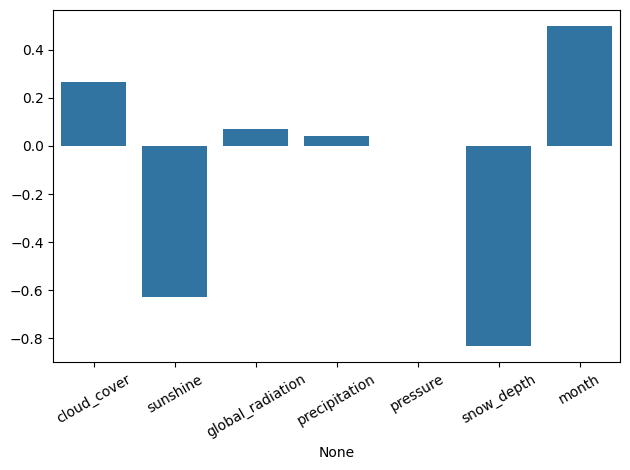

In [18]:
# Visualize feature importance using the coefficients
fig = plt.figure()
sns.barplot(x=X_train.columns, y=ridge.coef_)
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("feature_selection.png")
plt.show()

In [20]:
wandb.log({"feature_selection_plot": wandb.Image(fig)})


In [19]:
import pickle
pickle.dump(ridge, open("feature_selection_model.pkl", "wb"))

In [21]:

feature_selection_model = wandb.Artifact("feature_selection_model", type="model")
feature_selection_model.add_file("feature_selection_model.pkl")
run.log_artifact(feature_selection_model)



<Artifact feature_selection_model>

In [22]:
X = london[["cloud_cover", "global_radiation", "precipitation", "month"]]
y = london["mean_temp"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
# /content/london_weather.csv

In [23]:

def log_data(X_train, y_train, X_test, y_test):
    # Log the training and test data
    training_features = wandb.Artifact(name="X_train",
                               type="data",
                               description="Training features")
    X_train.to_csv("X_train.csv", index=False)
    training_features.add_file("/content/X_train.csv")
    run.log_artifact(training_features)

    training_labels = wandb.Artifact(name="y_train",
                               type="data",
                               description="Training labels")
    y_train.to_csv("y_train.csv", index=False)

    training_labels.add_file("/content/y_train.csv")
    run.log_artifact(training_labels)

    test_features = wandb.Artifact(name="X_test",
                               type="data",
                               description="Test features")
    X_test.to_csv("X_test.csv", index=False)
    test_features.add_file("/content/X_test.csv")
    run.log_artifact(test_features)

    test_labels = wandb.Artifact(name="y_test",
                               type="data",
                               description="Test labels")
    y_test.to_csv("y_test.csv", index=False)
    test_labels.add_file("/content/y_test.csv")
    run.log_artifact(test_labels)

log_data(X_train, y_train, X_test, y_test)

In [24]:
# Fit and evaluate the model
dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg.fit(X_train, y_train)
y_pred = dt_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r_squared = r2_score(y_test, y_pred)
print(rmse, r_squared)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


3.8627385194713346 0.5399282872125385


In [25]:

# Save and log the model and metrics
pickle.dump(dt_reg, open("baseline_decision_tree.pkl", "wb"))
baseline_model = wandb.Artifact("baseline_decision_tree", type="model")
baseline_model.add_file("baseline_decision_tree.pkl")
run.log_artifact(baseline_model)
wandb.log({"rmse": rmse, "r_squared": r_squared})

In [26]:
# Plot training residuals
wandb.log({"baseline_residuals_plot": wandb.sklearn.plot_residuals(dt_reg, X_train, y_train)})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
wandb: WARNING using only the first 100 datapoints to create chart residuals
wandb: WARNING using only the first 100 datapoints to create chart residuals


In [27]:
# Finish run
wandb.finish()

r_squared,▁
rmse,▁
r_squared,0.53993
rmse,3.86274


In [28]:
# Initialize a new run
run_v2 = wandb.init(project="predicting_london_temperature",
                 job_type="Hyperparameter tuning",
                 save_code=True)

In [29]:
# Split the data and create a KFold object
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
kf = KFold(n_splits=5, shuffle=True, random_state=42)


In [31]:

# Create the hyperparameter space
params = {"max_depth":[2, 5, 8, 12, 20],
          "min_samples_split": [2, 5, 8, 12, 20],
          "max_features": [1, 2, 3, 4],
          "random_state": [42]
          }

In [32]:

# Create a GridSearchCV object
dt_reg = DecisionTreeRegressor()
dt_reg_cv = GridSearchCV(dt_reg,
                         params,
                         cv=kf,
                         scoring="neg_root_mean_squared_error")


In [33]:
# Fit the data
dt_reg_cv.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 5, 8, 12, 20],
                         'max_features': [1, 2, 3, 4],
                         'min_samples_split': [2, 5, 8, 12, 20],
                         'random_state': [42]},
             scoring='neg_root_mean_squared_error')

In [34]:


# Evaluate and log performance
## GridSearchCV uses negative RMSE
## so you can convert it to positive
print(f"Best RMSE: {-1 * dt_reg_cv.best_score_})")
print(f"Best model: {dt_reg_cv.best_estimator_}")

Best RMSE: 2.932135504679972)
Best model: DecisionTreeRegressor(max_depth=8, max_features=4, min_samples_split=20,
                      random_state=42)


In [35]:


# Save and log the model, metrics, and parameters
pickle.dump(dt_reg_cv, open("tuned_decision_tree.pkl", "wb"))
tuned_decision_tree = wandb.Artifact("tuned_decision_tree", type="model")
tuned_decision_tree.add_file("tuned_decision_tree.pkl")
run_v2.log_artifact(tuned_decision_tree)
wandb.log({"rmse": -1 * dt_reg_cv.best_score_})
wandb.finish()

rmse,▁
rmse,2.93214
